# **Proyecto Final - Bigdata & Bioinformática**

 **Escuela de Ciencias Aplicadas e Ingenierías**

**Pregrado en Ingeniería Agronómimca**

**Universidad Eafit**

**Estudiantes:**
- Yeison Arango Ospina
- Sara Gallego Thorne
- Jayder Andres Juagibioy Satiaca

##**1. Configuración inical y preparación del entorno**

Esta sección importa todas las bibliotecas necesarias y establece semillas aleatorias para garantizar la reproducibilidad

In [1]:
# Cargar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm  # Para barras de progreso

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

##**2. Carga y análisis de entrenamiento**

Aquí se carga el dataset de entrenamiento desde un archivo Excel. Contiene valores RGB de píxeles etiquetados (columna 'X') donde:

- 1 = píxeles de aguacate enfermo

- 2 = píxeles de aguacate sano

- 3 = píxeles de fondo

La función *df.columns.str.strip()* elimina espacios en blanco en los nombres de columnas. Luego se muestra información básica del dataset para verificar su estructura.

In [20]:
# Cargar datos de entrenamiento
df = pd.read_excel("/content/drive/MyDrive/Bigdata&Bioinformática - Notebook/Proyecto Final /Aguacate.xlsx")
df.columns = df.columns.str.strip()

# Verificar y limpiar datos
print(f"Forma del dataframe: {df.shape}")
print(f"Valores nulos: {df.isnull().sum().sum()}")
print(f"Distribución de clases: {df['X'].value_counts()}")

Forma del dataframe: (2200, 4)
Valores nulos: 0
Distribución de clases: X
1    1000
2    1000
3     200
Name: count, dtype: int64


##**3. Balanceo opcional del dataset**

Esta sección implementa una técnica de submuestreo para balancear las clases, lo que puede ser útil si hay un desequilibrio significativo entre la cantidad de píxeles enfermos, sanos y de fondo. La técnica reduce cada clase al tamaño de la clase más pequeña. Esta funcionalidad está comentada por defecto (activarla dependerá del análisis del dataset).

In [21]:
# Balancear dataset si es necesario (muestreo)
min_class_count = df['X'].value_counts().min()
balanced_df = pd.DataFrame()
for clase in df['X'].unique():
    subset = df[df['X'] == clase]
    if len(subset) > min_class_count:
        subset = subset.sample(min_class_count, random_state=RANDOM_STATE)
    balanced_df = pd.concat([balanced_df, subset])

# Usar dataset balanceado si se desea
# df = balanced_df  # Descomentar para usar datos balanceados

##**4. Preparación de datos para entrenamiento**

Explicación: Se separan los datos en:

- **X**: características (valores RGB)
- **y**: etiquetas (1, 2, 3)

In [22]:
X = df[['R', 'G', 'B']]
y = df['X']  # 1 = enfermo, 2 = sano, 3 = fondo

##**5. Construcción del pipeline de machine learning**

Se crea un pipeline de dos etapas:

1. ***StandardScaler:*** normaliza los valores RGB para que tengan media=0 y desviación estándar=1
2. ***RandomForestClassifier:*** algoritmo de clasificación basado en árboles de decisión

El uso de ***n_jobs=-1*** permite el uso de todos los núcleos disponibles para acelerar el entrenamiento.

In [23]:
# Pipeline de entrenamiento
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

##**6. Búsqueda de hiperparámetros óptimos**

Esta sección utiliza ***GridSearchCV*** para encontrar la mejor combinación de hiperparámetros:

- ***n_estimators:*** número de árboles en el bosque
- ***max_depth:*** profundidad máxima de cada árbol
- ***min_samples_split:*** mínimo de muestras para dividir un nodo
- ***class_weight:*** ponderación de clases (útil para datasets desbalanceados)

Se usa validación cruzada estratificada ***(StratifiedKFold)*** con 5 particiones para evaluar cada combinación de parámetros.

In [24]:
# Búsqueda de hiperparámetros
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 15, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__class_weight': [None, 'balanced']  # Para manejar desbalance
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__class_weight': [None, 'balanced'],
                         'clf__max_depth': [None, 15, 30],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [50, 100, 200]},
             scoring='balanced_accuracy', verbose=1)

##**7. Evaluación del modelo**

Se obtiene el mejor modelo y se evalúa su rendimiento en los datos de entrenamiento. Se muestran:

- Mejores hiperparámetros encontrados
- Precisión global (accuracy)
- Reporte detallado de clasificación (precision, recall, f1-score)

In [25]:
# Evaluación del mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)

print("\n" + "="*50)
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Precisión general del mejor modelo:", accuracy_score(y, y_pred))
print("Reporte de clasificación:")
print(classification_report(y, y_pred, digits=3))


Mejores hiperparámetros: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Precisión general del mejor modelo: 0.9854545454545455
Reporte de clasificación:
              precision    recall  f1-score   support

           1      0.980     0.988     0.984      1000
           2      0.988     0.980     0.984      1000
           3      1.000     1.000     1.000       200

    accuracy                          0.985      2200
   macro avg      0.989     0.989     0.989      2200
weighted avg      0.985     0.985     0.985      2200



##**8. Visualización de la matriz de confusión**

Se crea y visualiza una matriz de confusión para evaluar el rendimiento del clasificador en cada clase. La matriz muestra:

- **Filas:** clases reales
- **Columnas:** clases predichas
- **Valores:** cantidad de píxeles

<Figure size 800x600 with 0 Axes>

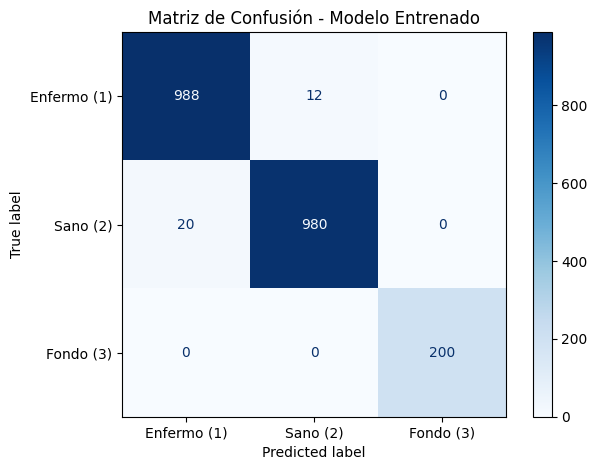

In [26]:
# Visualizar matriz de confusión
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Enfermo (1)', 'Sano (2)', 'Fondo (3)'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Modelo Entrenado")
plt.tight_layout()
plt.show()

##**9. Análisis de importancia de características**

 Esta sección visualiza la importancia relativa de cada canal de color (R, G, B) en la clasificación. Esto ayuda a entender qué componentes del color son más relevantes para detectar áreas enfermas vs sanas.

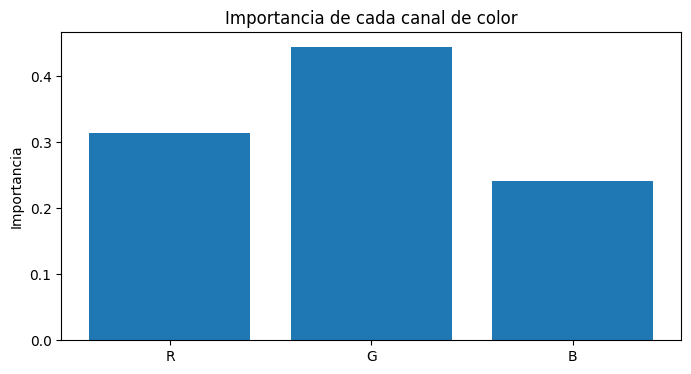

In [27]:
# Analizar importancia de características
if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
    importancias = best_model.named_steps['clf'].feature_importances_
    plt.figure(figsize=(8, 4))
    plt.bar(['R', 'G', 'B'], importancias)
    plt.title('Importancia de cada canal de color')
    plt.ylabel('Importancia')
    plt.show()

##**10. Configuración para segmentación de imágenes**

Se definen las carpetas de entrada/salida para las imágenes y se configura el mapa de colores para la visualización:

- **Rojo:** áreas enfermas
- **Verde:** áreas sanas
- **Blanco:** fondo

Se crea la lista de todas las imágenes a procesar y se selecciona una muestra aleatoria de 5 para visualización.

In [57]:
# Segmentar imágenes de la carpeta
input_folder = "/content/drive/MyDrive/Bigdata&Bioinformática - Notebook/Proyecto Final /Aguacate"
output_folder = os.path.join(input_folder, "Segmentadas")
os.makedirs(output_folder, exist_ok=True)

# Definir colores para visualización
colores = ['red', 'green', 'white']  # 1=Enfermo, 2=Sano, 3=Fondo
cmap = ListedColormap(colores)

# Procesar todas las imágenes
imagenes_totales = [f for f in os.listdir(input_folder) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
imagenes_mostrar = set(random.sample(imagenes_totales, min(5, len(imagenes_totales))))

##**11. Procesamiento de imágenes**

Este es el núcleo del procesamiento de imágenes. Para cada imagen:

1. Se carga la imagen y se extraen los píxeles RGB
2. Se procesa por lotes para evitar problemas de memoria con imágenes grandes
3. Se aplica el modelo entrenado para clasificar cada píxel
4. Se guarda la imagen segmentada (usando el mapa de colores)
5. Se calculan estadísticas:

  - Porcentaje de área enferma y sana
  - Estado general (enfermo/sano) basado en el porcentaje mayoritario


6. Se guardan los resultados para análisis posterior
7. Para imágenes seleccionadas, se almacenan datos adicionales para visualización

In [58]:
resultados = []
imagenes_para_visualizar = []  # Almacenar datos para visualización posterior

print(f"\nProcesando {len(imagenes_totales)} imágenes...")

for archivo in tqdm(imagenes_totales):
    ruta_img = os.path.join(input_folder, archivo)
    try:
        imagen = imread(ruta_img)[..., :3]  # Aseguramos 3 canales (RGB)
        alto, ancho, _ = imagen.shape
        pixeles = imagen.reshape(-1, 3)

        # Procesamiento por lotes para imágenes grandes
        batch_size = 100000  # Ajustar según memoria disponible
        predicciones = np.zeros(pixeles.shape[0], dtype=np.int8)

        for i in range(0, pixeles.shape[0], batch_size):
            batch = pixeles[i:i+batch_size]
            batch_norm = best_model.named_steps['scaler'].transform(batch)
            predicciones[i:i+batch_size] = best_model.named_steps['clf'].predict(batch_norm)

        segmentacion = predicciones.reshape(alto, ancho)

        # Guardar imagen segmentada
        plt.imsave(os.path.join(output_folder, f"seg_{archivo}"), segmentacion, cmap=cmap)

        # Calcular porcentajes
        mascara_aguacate = (segmentacion == 1) | (segmentacion == 2)
        pixeles_aguacate = segmentacion[mascara_aguacate]
        total = len(pixeles_aguacate)

        if total > 0:
            pct_enfermo = np.sum(pixeles_aguacate == 1) / total * 100
            pct_sano = np.sum(pixeles_aguacate == 2) / total * 100
            estado = "Enfermo" if pct_enfermo > 1 else "Sano"
        else:
            pct_enfermo = pct_sano = 0
            estado = "No determinado"

        resultados.append({
            'imagen': archivo,
            'porcentaje_enfermo': round(pct_enfermo, 2),
            'porcentaje_sano': round(pct_sano, 2),
            'estado': estado,
            'total_pixeles_aguacate': total
        })

        # Guardar datos para visualización posterior (solo para imágenes seleccionadas)
        if archivo in imagenes_mostrar:
            imagenes_para_visualizar.append({
                'nombre': archivo,
                'original': imagen.copy(),
                'segmentacion': segmentacion.copy(),
                'pct_enfermo': pct_enfermo,
                'pct_sano': pct_sano,
                'estado': estado,
                'total': total
            })

    except Exception as e:
        print(f"Error al procesar {archivo}: {str(e)}")


Procesando 466 imágenes...


  0%|          | 0/466 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
  0%|          | 1/466 [00:00<03:03,  2.54it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
  0%|          | 2/466 [00:00<03:02,  2.54it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
  1%|          | 3/466 [00:01<02:50,  2.71it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
  1%|          | 4/466 [00:01<02:50,  2.70it/s]/usr/local/li

##**12. Análisis y guardado de resultados**

Se crea un DataFrame con todos los resultados y se calculan estadísticas generales:

- Promedio de área enferma/sana
- Conteo de imágenes clasificadas en cada categoría

Los resultados se guardan en un archivo CSV para análisis posterior.

In [59]:
# Guardar y analizar resultados
df_resultados = pd.DataFrame(resultados)

# Análisis estadístico de resultados
print("\n" + "="*50)
print("ESTADÍSTICAS DE SEGMENTACIÓN:")
print(f"Total de imágenes procesadas: {len(df_resultados)}")
print(f"Promedio de área enferma: {df_resultados['porcentaje_enfermo'].mean():.2f}%")
print(f"Promedio de área sana: {df_resultados['porcentaje_sano'].mean():.2f}%")
print(f"Imágenes clasificadas como enfermas: {(df_resultados['porcentaje_enfermo'] > 50).sum()}")
print(f"Imágenes clasificadas como sanas: {(df_resultados['porcentaje_sano'] > 50).sum()}")

# Guardar resultados
df_resultados.to_csv(os.path.join(output_folder, "resumen_segmentacion.csv"), index=False)
print("\n✅ Segmentación finalizada. Resultados guardados en:", output_folder)


ESTADÍSTICAS DE SEGMENTACIÓN:
Total de imágenes procesadas: 466
Promedio de área enferma: 5.34%
Promedio de área sana: 94.66%
Imágenes clasificadas como enfermas: 4
Imágenes clasificadas como sanas: 462

✅ Segmentación finalizada. Resultados guardados en: /content/drive/MyDrive/Bigdata&Bioinformática - Notebook/Proyecto Final /Aguacate/Segmentadas


##**13. Visualización de resultados/ejemplos**

Para cada imagen de la muestra seleccionada, se crea una visualización con tres componentes:

1. Imagen original
2. Imagen segmentada (coloreada)
3. Gráfico de pastel mostrando la proporción de áreas enfermas/sanas

Esta sección está fuera del bucle principal para no interrumpir el procesamiento.


Mostrando 5 imágenes de ejemplo:


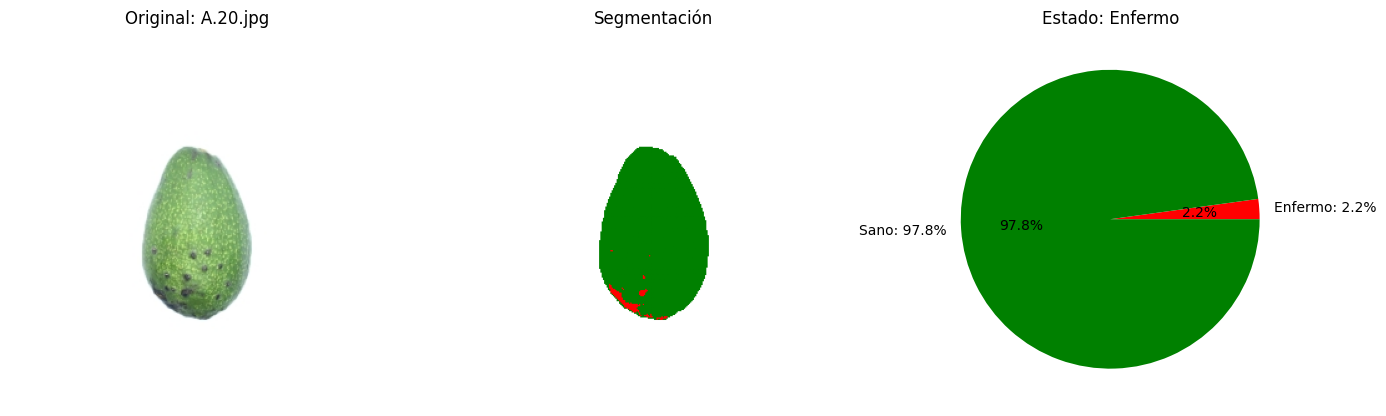

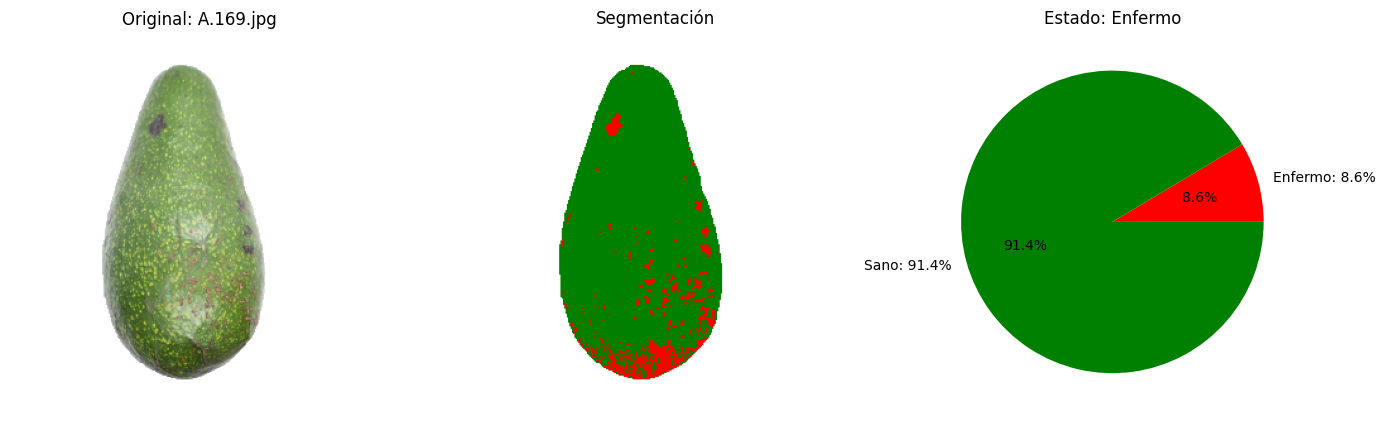

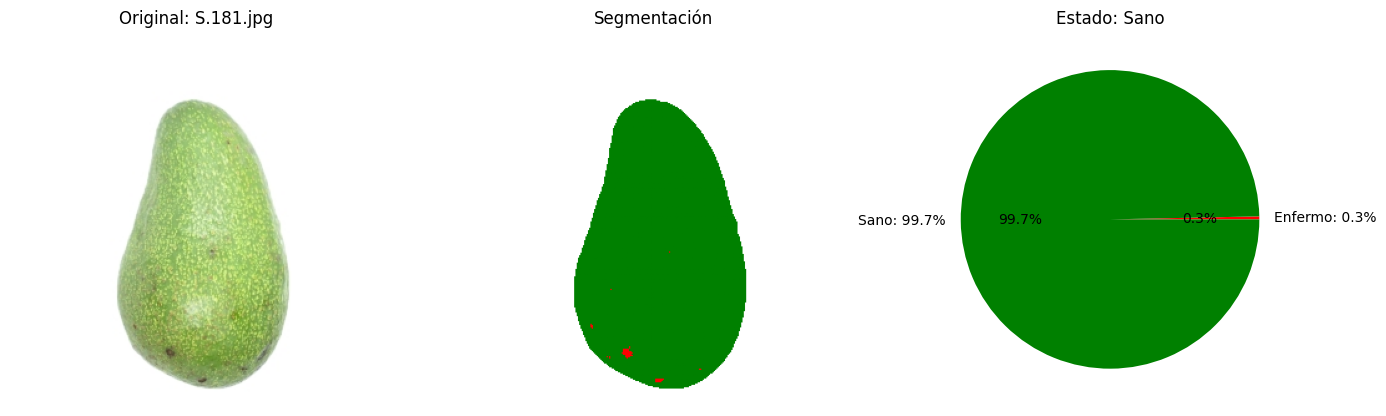

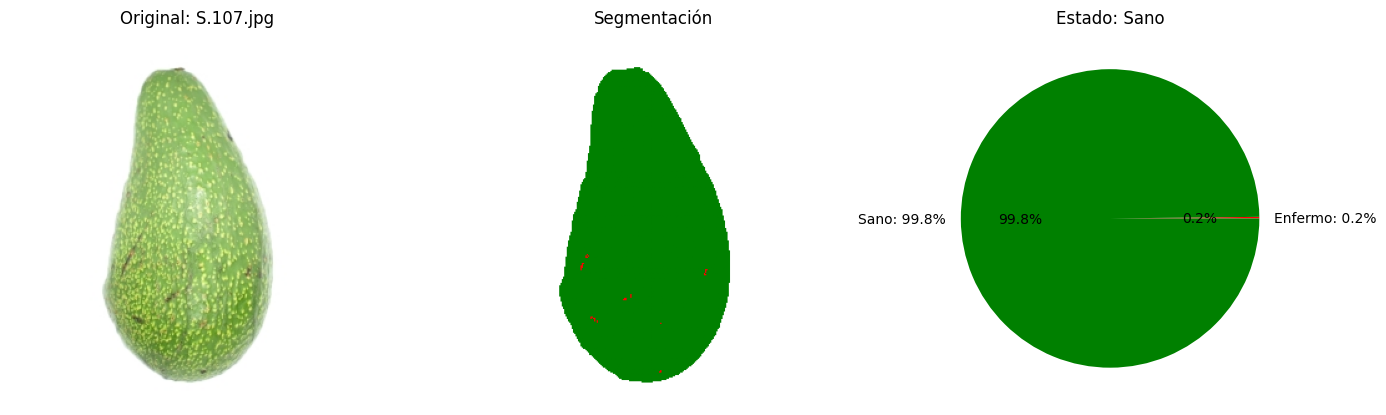

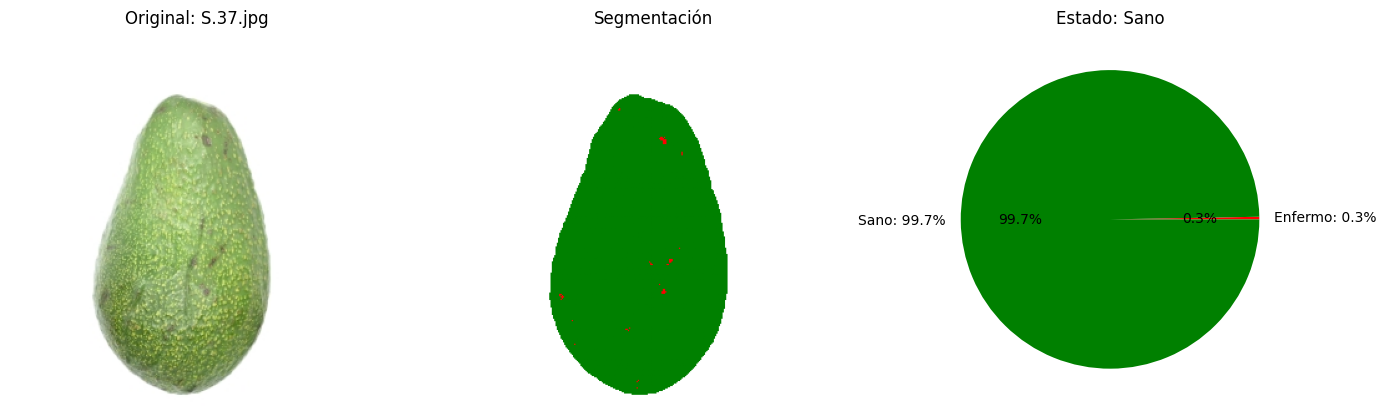

In [60]:
# Visualizar resultados
print("\n" + "="*50)
print(f"Mostrando {len(imagenes_para_visualizar)} imágenes de ejemplo:")

# Visualizar las imágenes seleccionadas
for datos_img in imagenes_para_visualizar:
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(datos_img['original'])
    plt.title(f"Original: {datos_img['nombre']}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(datos_img['segmentacion'], cmap=cmap)
    plt.title(f"Segmentación")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    # Gráfico de pastel con porcentajes
    if datos_img['total'] > 0:
        plt.pie([datos_img['pct_enfermo'], datos_img['pct_sano']],
                labels=[f'Enfermo: {datos_img["pct_enfermo"]:.1f}%',
                         f'Sano: {datos_img["pct_sano"]:.1f}%'],
                colors=['red', 'green'],
                autopct='%1.1f%%')
        plt.title(f"Estado: {datos_img['estado']}")
    else:
        plt.text(0.5, 0.5, "No se detectó aguacate",
                horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.show()

##**14. Visualización de estadísticos adicionales**

Se generan visualizaciones estadísticas adicionales:

1. Un diagrama de dispersión que muestra la relación entre el porcentaje de área sana vs. enferma
2. Histogramas que muestran la distribución de los porcentajes para cada categoría

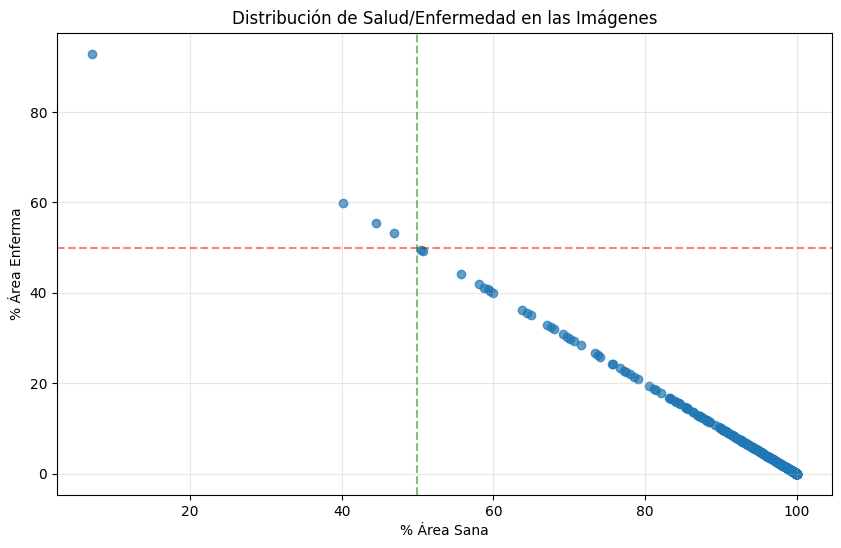

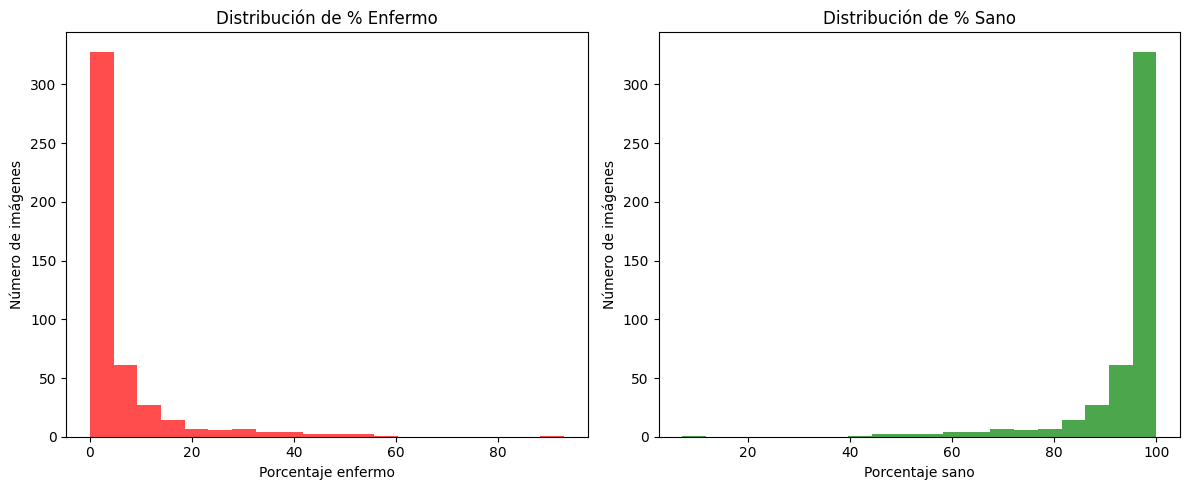

In [61]:
# Visualizar distribución de porcentajes
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados['porcentaje_sano'], df_resultados['porcentaje_enfermo'], alpha=0.7)
plt.xlabel('% Área Sana')
plt.ylabel('% Área Enferma')
plt.title('Distribución de Salud/Enfermedad en las Imágenes')
plt.grid(True, alpha=0.3)
plt.axhline(y=50, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=50, color='g', linestyle='--', alpha=0.5)
plt.show()

# Histograma de distribución de enfermedad
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df_resultados['porcentaje_enfermo'], bins=20, color='red', alpha=0.7)
plt.title('Distribución de % Enfermo')
plt.xlabel('Porcentaje enfermo')
plt.ylabel('Número de imágenes')

plt.subplot(1, 2, 2)
plt.hist(df_resultados['porcentaje_sano'], bins=20, color='green', alpha=0.7)
plt.title('Distribución de % Sano')
plt.xlabel('Porcentaje sano')
plt.ylabel('Número de imágenes')

plt.tight_layout()
plt.show()